In [6]:

! pip -q install pytorch_lightning transformers wandb sentence-transformers 

     |████████████████████████████████| 705 kB 28.3 MB/s 
     |████████████████████████████████| 4.7 MB 59.5 MB/s 
     |████████████████████████████████| 1.8 MB 25.1 MB/s 
     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 419 kB 68.1 MB/s 
     |████████████████████████████████| 5.9 MB 54.1 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
     |████████████████████████████████| 120 kB 74.1 MB/s 
     |████████████████████████████████| 122 kB 70.5 MB/s 
     |████████████████████████████████| 181 kB 58.2 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 157 kB 75.1 MB/s 
     |████████████████████████████████| 157 kB 79.9 MB/s 
     |████████████████████████████████| 157 kB 79.5 MB/s 
     |████████████████████████████████| 157 kB 80.9 MB/s 
     |████████████████████████████████| 157 kB 75.2 MB/s 
     |████████████████████████████████| 156 kB 81.3 MB/s 
     |████████████

In [7]:
import warnings 
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import glob
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import re
import math
import gc
from tqdm.notebook import tqdm_notebook
import wandb

import torch
import torch.nn as nn 
import torch.nn.functional as F
import transformers

import pytorch_lightning as pl
import pytorch_lightning

device =  torch.device('cuda' if torch.has_cuda else 'cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi

Thu Aug 11 09:05:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P6000        Off  | 00000000:00:05.0 Off |                  Off |
| 26%   28C    P8     8W / 250W |      2MiB / 24449MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Dataset and pre-trained weights

In [8]:
# load the models 
! wget -q "https://www.dropbox.com/s/58ns2jt8aj8yoxm/models.zip?dl=0"
! unzip -q models.zip?dl=0

# load python dataset
! wget -q "https://www.dropbox.com/s/eijnvwna66sq0rq/python.zip?dl=0"
! unzip -q python.zip?dl=0

# load javascript dataset
! wget -q "https://www.dropbox.com/s/rmzuylbwpj2l44y/javascript.zip?dl=0"
! unzip -q javascript.zip?dl=0

In [11]:
# please select between python or java script 

language = int( input("0: for python \n1: for javascript\n") )


if language == 0:

  language = "python"

  dir = f"./{language}/"
  load_model = "/content/models/python_model_2.ckpt"
else:

  language = "javascript"

  dir = f"./{language}/"
  load_model = "/content/models/js_model.ckpt"

0: for python 
1: for javascript
0


In [ ]:

def jsonl_list_to_dataframe(file_list, dir , columns=['code', 'docstring']):
    
    """
    input  : Directory 
    output : Dataframe that has code and docstring 
    """

    file_list =   glob.glob(f"{dir}/**.gz", recursive= True)

    return pd.concat([pd.read_json( f, orient='records', compression='gzip', lines=True)[columns] for f in file_list], sort=False)

def get_dfs(path):
    """
    input  : Directory 
    output : returns train, Validation and test  dataframe
    """
    
    dfs = []
    for split in ["train", "valid", "test"]:
        
        files = sorted( os.listdir( path+split  ) )
        df = jsonl_list_to_dataframe(files, path+split ) #.rename(columns = {'code': 'mthd', 'docstring': 'cmt'})
        dfs.append( df )
        
    return dfs

train, valid, test = get_dfs(dir)

train.shape, valid.shape, test.shape

((123889, 2), (8253, 2), (6483, 2))

In [ ]:
train.head()

,code,docstring
0,function createTypeScriptLanguageService(optio...,"#region Discovery, LanguageService & Setup"
1,function discoverAndReadFiles(options) {\n ...,Read imports and follow them until all files h...
2,"function getRealNodeSymbol(checker, node) {\n ...",#endregion #region Utils \nReturns the node's ...
3,"function shouldSkipAlias(node, declaration) {\...",Go to the original declaration for cases: (1)...
4,"function getTokenAtPosition(sourceFile, positi...",Get the token whose text contains the position


# Data Cleaning  

In [ ]:
def del_docstring_from_code(value):
    """
    input : code and docstring
    output clean code snippet  
    """
    if value[1] in value[0]:
        value[0] = value[0].replace(value[1] , "")


    return value[0]


train.code = [ del_docstring_from_code(value) for value in train.values]
test.code  = [ del_docstring_from_code(value) for value in test.values]
valid.code = [ del_docstring_from_code(value) for value in valid.values] 


train.shape, valid.shape, test.shape

((123889, 2), (8253, 2), (6483, 2))

In [ ]:
# remove html. tag from the code 

def remove_html(cmt):
    """
    input  : Docstring
    output : Clean comment  
    """
    return re.sub(r"<.?span[^>]*>|<.?code[^>]*>|<.?p[^>]*>|<.?hr[^>]*>|<.?h[1-3][^>]*>|<.?a[^>]*>|<.?b[^>]*>|<.?blockquote[^>]*>|<.?del[^>]*>|<.?dd[^>]*>|<.?dl[^>]*>|<.?dt[^>]*>|<.?em[^>]*>|<.?i[^>]*>|<.?img[^>]*>|<.?kbd[^>]*>|<.?li[^>]*>|<.?ol[^>]*>|<.?pre[^>]*>|<.?s[^>]*>|<.?sup[^>]*>|<.?sub[^>]*>|<.?strong[^>]*>|<.?strike[^>]*>|<.?ul[^>]*>|<.?br[^>]*>", "", cmt)


train.docstring = train.docstring.apply(lambda x : remove_html(x))
test.docstring = test.docstring.apply(lambda x : remove_html(x))
valid.docstring = valid.docstring.apply(lambda x : remove_html(x))


train.shape, valid.shape, test.shape

((123889, 2), (8253, 2), (6483, 2))

In [ ]:
# get rid of the rowes that has < code > tag in there docstring 

def has_code(cmt) :
    
    '''
    Determinine if the given comment contains the HTML <code> tag
    '''

    if '<code>' in cmt: return True
    else: return False


train = train[ ~ train.docstring.apply(lambda x : has_code(x) ) ]
test  = test[ ~ test.docstring.apply(lambda x : has_code(x) ) ]
valid = valid[ ~ valid.docstring.apply(lambda x : has_code(x) ) ]


train.shape, valid.shape, test.shape

((123889, 2), (8253, 2), (6483, 2))

In [ ]:
# bring everything to lowercase and remove extra space

train = train.applymap(lambda row : ' '.join(row.split()).lower())
test = test.applymap(lambda row : ' '.join(row.split()).lower())
valid = valid.applymap(lambda row : ' '.join(row.split()).lower())


train.shape, valid.shape, test.shape

((123889, 2), (8253, 2), (6483, 2))

In [ ]:
# delet the rows where the length of the docstring is longer than the length of the code! This is becase some time code comment tend to have extra 
# info which is not available in real time 


train = train[ ~ train.apply(lambda row : len(row.code) < len(row.docstring) , axis= 1 ) ]

test = test[ ~ test.apply(lambda row : len(row.code) < len(row.docstring) , axis= 1 ) ]

valid = valid[ ~ valid.apply(lambda row : len(row.code) < len(row.docstring) , axis= 1 ) ] 

train.shape, valid.shape, test.shape

((106737, 2), (7153, 2), (5596, 2))

In [ ]:
# Remove the rows that has missing docstring  

train = train[ ~ ( train.docstring == '') ]
test  = test[ ~ ( test.docstring == '') ]
valid = valid[ ~ ( valid.docstring == '') ]


train.shape, valid.shape, test.shape

((106734, 2), (7151, 2), (5596, 2))

In [ ]:
# remove duplicate values 

train = train[ ~ train.docstring.duplicated() ]
test = test[ ~ test.docstring.duplicated() ]
valid = valid[ ~ valid.docstring.duplicated() ]


train.shape, valid.shape, test.shape

((98142, 2), (6677, 2), (5298, 2))

In [ ]:
train = train.reset_index().drop(labels = 'index', axis = 1)
test = test.reset_index().drop(labels = 'index', axis = 1)
valid = valid.reset_index().drop(labels = 'index', axis = 1)

# Tokenization

In [ ]:
# lets find the max length of both code and description sequence 

In [ ]:
# initialise our tokenizer 

tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [ ]:
code_lengths = [ len( tokenizer.encode( code, add_special_tokens= False ) ) for code in train.code.values ]

cmt_lengths = [ len( tokenizer.encode( comment, add_special_tokens= False ) ) for comment in train.docstring.values ]

Token indices sequence length is longer than the specified maximum sequence length for this model (1091 > 512). Running this sequence through the model will result in indexing errors


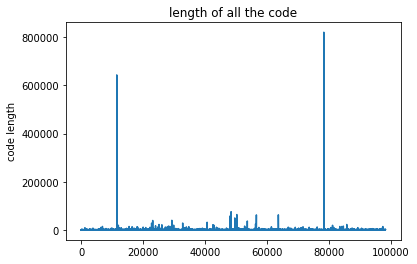

In [ ]:
# plot all the code lengths 

plt.plot(code_lengths)
plt.title("length of all the code")
plt.ylabel("code length")
plt.show()

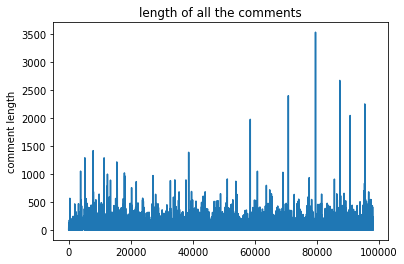

In [ ]:
# plot all comment lengths 

plt.plot(cmt_lengths)
plt.title("length of all the comments")
plt.ylabel("comment length")
plt.show()

as we see from the above graph, its clear that we have some outliers. 

In [ ]:
# Outliers 

code_outlier, cmt_outlier = int( np.quantile(code_lengths, 0.90) ), int( np.quantile(cmt_lengths, 0.90)  )

code_outlier, cmt_outlier

(473, 78)

In [ ]:
# add a piece of comment to code 

np.mean( cmt_lengths )

37.26497320209492

In [ ]:
# lets only consider the average length of the code and comment 

code_max_length, cmt_max_length =  256  ,  64      # "int(np.average(code_lengths))", int(np.average(cmt_lengths)) 

code_max_length, cmt_max_length

(256, 64)

In [ ]:
# drop all the records that are greater than 256

long_code_index = [ i  for i, length in  enumerate( code_lengths ) if length > code_max_length ]

# drop all the recodrs in the index
train.drop(index = long_code_index, inplace = True)

# reset index
train = train.reset_index().drop(labels = 'index', axis = 1) 


# drop all the records that are greater than 64
cmt_lengths = [ len( tokenizer.encode( comment, add_special_tokens= False ) ) for comment in train.docstring.values ]

long_cmt_index = [ i  for i, length in  enumerate( cmt_lengths ) if length > cmt_max_length ]

# drop all the recodrs in the index
train.drop(index = long_cmt_index, inplace = True)

train.shape, valid.shape, test.shape

((67258, 2), (6677, 2), (5298, 2))

In [ ]:
# let us tokenize the data 

BATCH_SIZE = 16


# To tokenize the code 
def code_tokenizer(data : list):
    """
    input  :  list of code to be tokenized
    output :  input_ids and attention_mask tensor of type long 
    """
    
    input_ids = []
    attention_mask = [] 

    for str in data: 
        encoded = tokenizer.encode_plus( text= str , max_length= code_max_length, padding= 'max_length', truncation= True)
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])


    # covert the input ids and the attention mask to type tensor 
    input_ids = torch.LongTensor(input_ids)
    attention_mask = torch.LongTensor(attention_mask)

    print(f"shape of the code input_ids -> {input_ids.shape}")
    print(f"shape of the code attention_mask -> {attention_mask.shape}")

    return input_ids, attention_mask 


# let us tokenize docstring 
def comment_tokenizer(data : list):
    """
    input  :  list of comment to be tokenized
    output :  input_ids and attention_mask tensor of type long 
    """
    
    input_ids = []
    attention_mask = [] 

    for str in data: 
        encoded = tokenizer.encode_plus( text= str , max_length= cmt_max_length, padding= 'max_length', truncation= True)
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])


    # covert the input ids and the attention mask to type tensor 
    input_ids = torch.LongTensor(input_ids)
    attention_mask = torch.LongTensor(attention_mask)

    print(f"shape of the comment input_ids -> {input_ids.shape}")
    print(f"shape of the comment attention_mask -> {attention_mask.shape}")

    return input_ids, attention_mask


# creating a dataloader 
def make_data_loader(data : pd.DataFrame ) -> torch.utils.data.DataLoader2 :
    """
    input  : pandas data frame of code docstring pair 
    output : DataLaoder that has src_input_ids, src_attention_mask, tgt_input_ids, tgt_attention_mask
    """

    assert 'code' in test.columns , "rename the function column name to code "
    assert 'docstring' in test.columns , "rename the description column name to docstring "

    SRC_input_ids, SRC_attention_mask  = code_tokenizer(data.code.values)          # reurns input ids and attention mask of both source  -> shape [N, S] 
    TGT_input_ids, TGT_attention_mask  = comment_tokenizer(data.docstring.values) # reurns input ids and attention mask of both source  -> shape [N, T] 

    data = torch.utils.data.TensorDataset( SRC_input_ids, SRC_attention_mask, TGT_input_ids, TGT_attention_mask ) # has four values in one variable 

    sampler =  torch.utils.data.RandomSampler(data)

    data_loader = torch.utils.data.DataLoader(dataset= data, batch_size= BATCH_SIZE, num_workers= 3, drop_last=True, sampler= sampler) # shape [N, S] -> [batchsize, sequence length]
    
    return data_loader

In [ ]:
# Function call to create a data loader for thge model

print("For train data")
Train = make_data_loader(train)

For train data
shape of the code input_ids -> torch.Size([67258, 256])
shape of the code attention_mask -> torch.Size([67258, 256])
shape of the comment input_ids -> torch.Size([67258, 64])
shape of the comment attention_mask -> torch.Size([67258, 64])


In [ ]:
print("For validation data")
Valid = make_data_loader(valid)

For validation data
shape of the code input_ids -> torch.Size([6677, 256])
shape of the code attention_mask -> torch.Size([6677, 256])
shape of the comment input_ids -> torch.Size([6677, 64])
shape of the comment attention_mask -> torch.Size([6677, 64])


In [ ]:
print("For test data")
Test = make_data_loader(test)

For test data
shape of the code input_ids -> torch.Size([5298, 256])
shape of the code attention_mask -> torch.Size([5298, 256])
shape of the comment input_ids -> torch.Size([5298, 64])
shape of the comment attention_mask -> torch.Size([5298, 64])


## Develop model

In [ ]:
class Beam(object):
    def __init__(self, size,sos,eos):
        
        """
        @article{DBLP:journals/corr/abs-2102-04664,
          author    = {Shuai Lu and
                       Daya Guo and
                       Shuo Ren and
                       Junjie Huang and
                       Alexey Svyatkovskiy and
                       Ambrosio Blanco and
                       Colin B. Clement and
                       Dawn Drain and
                       Daxin Jiang and
                       Duyu Tang and
                       Ge Li and
                       Lidong Zhou and
                       Linjun Shou and
                       Long Zhou and
                       Michele Tufano and
                       Ming Gong and
                       Ming Zhou and
                       Nan Duan and
                       Neel Sundaresan and
                       Shao Kun Deng and
                       Shengyu Fu and
                       Shujie Liu},
          title     = {CodeXGLUE: {A} Machine Learning Benchmark Dataset for Code Understanding
                       and Generation},
          journal   = {CoRR},
          volume    = {abs/2102.04664},
          year      = {2021}
        }
        """
        self.size = size
        self.tt = torch.cuda
        # The score for each translation on the beam.
        self.scores = self.tt.FloatTensor(size).zero_()
        # The backpointers at each time-step.
        self.prevKs = []
        # The outputs at each time-step.
        self.nextYs = [self.tt.LongTensor(size)
                       .fill_(0)]
        self.nextYs[0][0] = sos
        # Has EOS topped the beam yet.
        self._eos = eos
        self.eosTop = False
        # Time and k pair for finished.
        self.finished = []

    def getCurrentState(self):
        "Get the outputs for the current timestep."
        batch = self.tt.LongTensor(self.nextYs[-1]).view(-1, 1)
        return batch

    def getCurrentOrigin(self):
        "Get the backpointers for the current timestep."
        return self.prevKs[-1]

    def advance(self, wordLk):
        """
        Given prob over words for every last beam `wordLk` and attention
        `attnOut`: Compute and update the beam search.
        Parameters:
        * `wordLk`- probs of advancing from the last step (K x words)
        * `attnOut`- attention at the last step
        Returns: True if beam search is complete.
        """
        numWords = wordLk.size(1)

        # Sum the previous scores.
        if len(self.prevKs) > 0:
            beamLk = wordLk + self.scores.unsqueeze(1).expand_as(wordLk)

            # Don't let EOS have children.
            for i in range(self.nextYs[-1].size(0)):
                if self.nextYs[-1][i] == self._eos:
                    beamLk[i] = -1e20
        else:
            beamLk = wordLk[0]
        flatBeamLk = beamLk.view(-1)
        bestScores, bestScoresId = flatBeamLk.topk(self.size, 0, True, True)

        self.scores = bestScores

        # bestScoresId is flattened beam x word array, so calculate which
        # word and beam each score came from
        prevK = bestScoresId // numWords
        self.prevKs.append(prevK)
        self.nextYs.append((bestScoresId - prevK * numWords))


        for i in range(self.nextYs[-1].size(0)):
            if self.nextYs[-1][i] == self._eos:
                s = self.scores[i]
                self.finished.append((s, len(self.nextYs) - 1, i))

        # End condition is when top-of-beam is EOS and no global score.
        if self.nextYs[-1][0] == self._eos:
            self.eosTop = True

    def done(self):
        return self.eosTop and len(self.finished) >=self.size

    def getFinal(self):
        if len(self.finished) == 0:
            self.finished.append((self.scores[0], len(self.nextYs) - 1, 0))
        self.finished.sort(key=lambda a: -a[0])
        if len(self.finished) != self.size:
            unfinished=[]
            for i in range(self.nextYs[-1].size(0)):
                if self.nextYs[-1][i] != self._eos:
                    s = self.scores[i]
                    unfinished.append((s, len(self.nextYs) - 1, i)) 
            unfinished.sort(key=lambda a: -a[0])
            self.finished+=unfinished[:self.size-len(self.finished)]
        return self.finished[:self.size]

    def getHyp(self, beam_res):
        """
        Walk back to construct the full hypothesis.
        """
        hyps=[]
        for _,timestep, k in beam_res:
            hyp = []
            for j in range(len(self.prevKs[:timestep]) - 1, -1, -1):
                hyp.append(self.nextYs[j+1][k])
                k = self.prevKs[j][k]
            hyps.append(hyp[::-1])
        return hyps
    
    def buildTargetTokens(self, preds):
        sentence=[]
        for pred in preds:
            tokens = []
            for tok in pred:
                if tok==self._eos:
                    break
                tokens.append(tok)
            sentence.append(tokens)
        return sentence

In [ ]:
class Code_Comment_Generator(pl.LightningModule):

    def __init__(self, encoder, decoder, d_model, src_vocab_size, tgt_vocab_Size, pad_idx, dropout, src_max_length, tgt_max_length, config, lr, epoch, tokenizer ):

        super(Code_Comment_Generator, self).__init__() 

        
        self.d_model = d_model
        self.pad_idx = pad_idx
        self.lr = lr
        self.epoch = epoch
        self.tgt_max_length = tgt_max_length #
        self.beam_size = 10
        self.sos_id = 0
        self.eos_id =2
        self.tokenizer = tokenizer

        self.test_cases = []        
        self.eval_counter = 0

        # pretrained config 
        self.config = config

        # Roberta Encoder  layer 
        self.encoder = encoder

        # Decoder Transformers 
        self.decoder = decoder


        # Register buffer 
        self.register_buffer("bias", torch.tril(torch.ones(2048, 2048))) # This is typically used to register a buffer that should not to be considered a model parameter.

        # dense layers 
        self.dense_layer = nn.Linear(in_features= self.d_model, 
                                out_features= self.d_model)


        # generator
        self.generator = nn.Linear(in_features= self.d_model, 
                                out_features= tgt_vocab_Size,  bias=False)

        self.dropout = nn.Dropout(p=dropout)

        # final activation 
        self.log_softmax = nn.LogSoftmax(dim= -1)
        
        # sharing weights between the encoder and the decoder 
        self.share_weights() 

        

    def share_weights(self):
        """ 
            This is to ensure we are sharing weights between the encoder and fianl dense layer 
        """

        if self.config.torchscript:
            self.generator.weight = nn.Parameter( data =  self.encoder.embeddings.word_embeddings.weight.clone()) 
        
        else: 
            self.generator.weight = self.encoder.embeddings.word_embeddings.weight

    
    def forward(self, src = None, src_key_padding_mask= None, tgt= None, tgt_key_padding_mask= None):
        """ 
        input  : source and taget tokens and attention mask 
        output : logits

        """


        # encoder output, this gives us the context vector which is present in the last decoder layer 

        encoder_output = self.encoder(src, attention_mask = src_key_padding_mask )[0]# considering the output of the last encoder layer  : shape -> torch.Size([32, 212, 768]) -> [N,S,E]
        encoder_output = encoder_output.permute([1,0,2]).contiguous() # rearanging tensor to shape -> torch.Size([212,32,768]) -> [S,N,E] 

        if tgt is not None: 

          tgt_mask = -1e4 *(1-self.bias[:tgt.shape[1],:tgt.shape[1]]).to(device= device) # shape -> trg_mask > torch.Size([42, 42])
      
          # encode the target embeddings 
          tgt_embedding = self.encoder.embeddings(tgt)                    # shape: torch.Size([32, 42, 768]) -> [N, T, E]
          tgt_embedding = tgt_embedding.permute([1,0,2]).contiguous()     # shape: torch.Size([42, 32, 768]) -> [T, N, E]

          # memeory key padding mask 
          memory_key_padding_mask = (1-src_key_padding_mask).bool()      # shape : torch.Size([32, 212])     -> [N, E]
        
        
          # output of the decoder 
          output = self.decoder(tgt = tgt_embedding, 
                                  memory = encoder_output, 
                                  tgt_mask = tgt_mask, 
                                  memory_key_padding_mask = memory_key_padding_mask )               # torch.Size([42, 32, 768]) -> T, N, E




          output =    torch.tanh( self.dropout(   self.dense_layer(output)  ) ).permute([1,0,2]).contiguous()  # activation + FC_1         # torch.Size([42, 32, 768])  -> T, N, E

          output =  self.generator(output)                    # output shape :- torch.Size([42, 32, 50265]) -> T, N, TGT_Vocb_size


          # calculate loss 
          active_loss = tgt_key_padding_mask[: , 1: ].ne(0).view(-1) == 1      # shape -> torch.Size([1312]) N*(T-1)

          shift_logits = output[:, :-1, :].contiguous()                        # shape -> torch.Size([32, 41, 50265]) N, (T-1), TGT_vocab_size

          shift_labels = tgt[:, 1:].contiguous()                            # shape -> torch.Size([32, 41])        N, (T-1)


          # flatten the tokens and find the loss 
          y_hat = shift_logits.view(-1, shift_logits.shape[-1])[active_loss]  # predicted value flatened
          y     = shift_labels.view(-1)[active_loss]                          # actual value flatten

          # find the cross entropy loss 
          loss = F.cross_entropy(y_hat ,  y , ignore_index = self.pad_idx )

          # memory management 
          del output
          torch.cuda.empty_cache()
          gc.collect()
          pl.utilities.memory.garbage_collection_cuda()
          pl.utilities.memory.get_gpu_memory_map()
          

          return loss #, loss*active_loss.sum() # train loss, evaluation loss 
        
        else: 
          # prediction 
          preds = []

          zero=torch.cuda.LongTensor(1).fill_(0)

          for i in range(src.shape[0]):

            context = encoder_output[:,i:i+1]

            context_mask = src_key_padding_mask[i:i+1,:]

            beam = Beam(self.beam_size, self.sos_id, self.eos_id) ####

            input_ids=beam.getCurrentState()

            context=context.repeat(1, self.beam_size,1)

            context_mask=context_mask.repeat(self.beam_size,1)     

            for _ in range(self.tgt_max_length):   #######
              
              if beam.done():
                break

              tgt_mask=-1e4 *(1-self.bias[:input_ids.shape[1],:input_ids.shape[1]]) 

              tgt_embedding = self.encoder.embeddings(input_ids).permute([1,0,2]).contiguous() 

              # memeory key padding mask 
              memory_key_padding_mask = (1-context_mask).bool()      # shape : torch.Size([32, 212])     -> [N, E]
            
            
              # output of the decoder 
              output = self.decoder(tgt = tgt_embedding, 
                                      memory = context, 
                                      tgt_mask = tgt_mask, 
                                      memory_key_padding_mask = memory_key_padding_mask )               # torch.Size([42, 32, 768]) -> T, N, E




              output =  torch.tanh( self.dropout(   self.dense_layer(output)  ) ).permute([1,0,2]).contiguous()[:,-1,:]  # activation + FC_1         # torch.Size([42, 32, 768])  -> T, N, E

              output =  self.log_softmax( self.generator(output) ).data               # output shape :- torch.Size([42, 32, 50265]) -> T, N, TGT_Vocb_size

              beam.advance(output)

              input_ids.data.copy_(input_ids.data.index_select(0, beam.getCurrentOrigin()))
              input_ids=torch.cat((input_ids,beam.getCurrentState()),-1)

            hyp= beam.getHyp(beam.getFinal())
            pred=beam.buildTargetTokens(hyp)[:self.beam_size]
            pred=[torch.cat([x.view(-1) for x in p]+[zero]*(self.tgt_max_length -len(p))).view(1,-1) for p in pred]
            preds.append(torch.cat(pred,0).unsqueeze(0))
          
          preds=torch.cat(preds,0)   

          del output
          del context
          torch.cuda.empty_cache()
          gc.collect()
          pl.utilities.memory.garbage_collection_cuda()
          pl.utilities.memory.get_gpu_memory_map() 

          return preds


    def training_step(self, batch, batch_indx): 


        # train model
        self.train()

        # unrap and load all the trensors to device
        src, src_key_padding_mask, tgt, tgt_key_padding_mask = tuple( i.to(device) for i in batch)

        #returns loss
        Loss  = self( src, src_key_padding_mask, tgt, tgt_key_padding_mask )

        # log the loss 
        self.log(name= "tran_loss", value= Loss, on_step= True, on_epoch=True, prog_bar= True, logger= True)

        # memory management
        gc.collect()
        pl.utilities.memory.garbage_collection_cuda()
        pl.utilities.memory.get_gpu_memory_map()

        return Loss

    def validation_step(self, batch, batch_indx): 


        # evaluate model
        self.eval()

        if self.eval_counter == 400 : # self.train_dataloader().batch_size

          code = " def search_features(self, search): if isinstance(search, string_types): search = [search] search = [s.replace('*', '.*') for s in search] cols = list(self.data.columns) results = [] for s in search: results.extend([f for f in cols if re.match(s + '$', f)]) return list(set(results)) " 
          doc = "returns all features that match any of the elements in the input list."

          print(f"generated cmt : {self.generate_comment(code) }")
          print(f"original cmt : {doc}")  

          self.test_cases.append(self.generate_comment(code))

          self.eval_counter = 0


        self.eval_counter += 1

        # unrap and load all the trensors to device
        src, src_key_padding_mask, tgt, tgt_key_padding_mask = tuple( i.to(device) for i in batch)

        #returns loss
        Loss  = self( src, src_key_padding_mask, tgt, tgt_key_padding_mask )


        # log the loss 
        self.log(name= "validation_loss", value= Loss, on_step= True, on_epoch=True, prog_bar= True, logger= True)

        # memory management
        gc.collect()
        pl.utilities.memory.garbage_collection_cuda()
        pl.utilities.memory.get_gpu_memory_map()

        return Loss


    def configure_optimizers(self):


        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ['bias', 'LayerNorm.weight']

        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': 0.0 },
            {'params': [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr = self.lr , eps= 1e-8 )
        
        nn.utils.clip_grad_norm_(self.parameters(), 1.0)

        torch.autograd.set_detect_anomaly(True)

        lr_scheduler = {
            'scheduler' : transformers.get_linear_schedule_with_warmup(optimizer= optimizer, num_warmup_steps = 5000, num_training_steps= self.epoch * len(Test)  ), 
            'interval'  : "step", 
            'frequency' : 1, 
            'monitor'   : "validation_loss", 
        }



        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def train_dataloader(self):

      return  Train

    def val_dataloader(self):    

      return Valid


    def generate_comment(self, code):
      """
      input : single code string 
      output : Generated comment 
      """

      tokenized = self.tokenizer.encode_plus(code, max_length= 256, padding='max_length', return_attention_mask= True, truncation= True )

      src = torch.LongTensor(tokenized['input_ids'] ).unsqueeze(1).reshape(1,-1).to(device)
      src_key_padding_mask = torch.LongTensor(tokenized['attention_mask'] ).unsqueeze(1).reshape(1,-1).to(device)

      gen_cmt = []

      preds = self(src, src_key_padding_mask)

      for pred in preds:
        t  = pred[0].cpu().numpy()
        t=list(t)
        if 0 in t:
          t=t[:t.index(0)]
        text = self.tokenizer.decode(t,clean_up_tokenization_spaces=False)
        
        gen_cmt.append(text)

      return gen_cmt
 

In [ ]:
# log in to weight and bias 

wandb.login()

# !wandb login --relogin. # eff91dd48ca6e7c55dfef9359e810cf3747cd6a2

wandb: Currently logged in as: syedjunaidiqbal. Use `wandb login --relogin` to force relogin


True

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger


In [ ]:
#pretrained configuration
config = transformers.RobertaConfig.from_pretrained("microsoft/codebert-base")

d_model = config.hidden_size
src_vocab_size = tokenizer.vocab_size
tgt_vocab_Size = tokenizer.vocab_size
pad_idx = tokenizer.pad_token_id
dropout = 0.5
src_max_length = code_max_length
tgt_max_length = cmt_max_length
epoch = 1000
lr = 5e-5

# object of seq2seql model
# seq2seql = Seq2Seq(d_model, src_vocab_size, tgt_vocab_Size, pad_idx, dropout, src_max_length, tgt_max_length, encoder, decoder, config ).to(device = device)

# Roberta Encoder  layer 
encoder = transformers.RobertaModel.from_pretrained(pretrained_model_name_or_path= "microsoft/codebert-base", config =  config ) 


# Decoder Transformers 
decoder_layer = torch.nn.TransformerDecoderLayer(d_model= config.hidden_size, nhead= config.num_attention_heads)
decoder = torch.nn.TransformerDecoder(decoder_layer= decoder_layer, num_layers= 6)

# lightning model 
model = Code_Comment_Generator(encoder, decoder, d_model, src_vocab_size, tgt_vocab_Size, pad_idx, dropout, src_max_length, tgt_max_length, config, lr, epoch, tokenizer).to(device)


In [ ]:
# lightning configuration

lr_monitor = LearningRateMonitor(logging_interval = "step" )

early_stopping = EarlyStopping(monitor= "validation_loss", 
                               min_delta = 0.001,
                               patience= 5, 
                               strict= True, 
                               verbose= True, 
                               mode = 'min') 

model_checkpoint = ModelCheckpoint(dirpath= f"./saved_{language}_model_weights/", 
                                   save_last=True, 
                                   monitor="validation_loss",  
                                   save_on_train_epoch_end = True, 
                                   mode="min", 
                                   save_top_k = 0)


wandb_logger = WandbLogger(name= f'Transformers_for_{language}_Code_Comment_Generator_code_size_256_with_code_comment', 
                           project='Desertation_Final_extras', 
                           log_model= True, 
                           save_dir = f"./saved_{language}_model_weights/" )

wandb_logger.watch(model, log="all")

trainer = Trainer(callbacks= [lr_monitor, early_stopping, model_checkpoint], 
                  devices= 1 , 
                  gradient_clip_algorithm= 'norm', 
                  accelerator='gpu', 
                  enable_progress_bar= True, 
                  default_root_dir = f"./saved_{language}_model_weights/default_root_dir/", 
                  max_epochs = epoch , 
                  logger = wandb_logger, 
                  strategy="dp" , precision=16) 

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# load pre-trained weights if available, else train from scratch 
 
if os.path.exists("/content/models"):

  checkpoint = torch.load(load_model)
  model.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | encoder     | RobertaModel       | 124 M 
1 | decoder     | TransformerDecoder | 47.3 M
2 | dense_layer | Linear             | 590 K 
3 | generator   | Linear             | 38.6 M
4 | dropout     | Dropout            | 0     
5 | log_softmax | LogSoftmax         | 0     
---------------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
345.007   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric validation_loss improved. New best score: 5.409


Validation: 0it [00:00, ?it/s]

generated cmt : ['returns the list of the given list of the given list of the given list of the given list of the given list of the given list. @param {array} search @param {array} searcharray @return {array}']
original cmt : returns all features that match any of the elements in the input list.


Metric validation_loss improved by 0.686 >= min_delta = 0.001. New best score: 4.723


Validation: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.442 >= min_delta = 0.001. New best score: 4.282


Validation: 0it [00:00, ?it/s]

generated cmt : ['returns the list of features in the list of features']
original cmt : returns all features that match any of the elements in the input list.


Metric validation_loss improved by 0.174 >= min_delta = 0.001. New best score: 4.108


Validation: 0it [00:00, ?it/s]

Metric validation_loss improved by 0.151 >= min_delta = 0.001. New best score: 3.957


Validation: 0it [00:00, ?it/s]

generated cmt : ['search for features']
original cmt : returns all features that match any of the elements in the input list.


Metric validation_loss improved by 0.018 >= min_delta = 0.001. New best score: 3.938


In [ ]:
"""
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,600000000)
"""